In [478]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix
solvers.options['show_progress']=False

In [483]:
def plot_heat_map(table,title=""):
    #print(table)
    plt.pcolor(table)
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    plt.show()

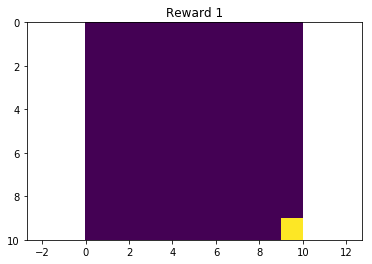

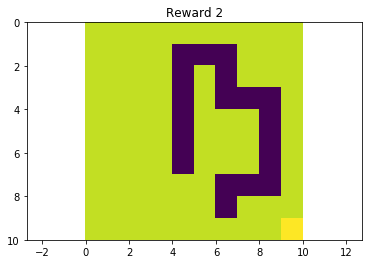

In [484]:
# QUESTION 1

reward_table_1 = np.zeros((10,10))
reward_table_1[9,9] = 1

reward_table_2 = np.zeros((10,10))
reward_table_2[1:7,4] = -100
reward_table_2[1,5] = -100
reward_table_2[1:4,6] = -100
reward_table_2[7:9,6] = -100
reward_table_2[3,7] = -100
reward_table_2[7,7] = -100
reward_table_2[3:8,8] = -100
reward_table_2[9,9] = 10

# Plot Rewards
plot_heat_map(reward_table_1,"Reward 1")
plot_heat_map(reward_table_2,"Reward 2")

In [517]:
# QUESTION 2: Value Iteration

def get_next_state(r, c, executed_action, state_shape):
    # Case where the resulting action is "up"
    if executed_action == 0:
        next_r, next_c = (max(r-1,0), c)
    # Case where the resulting action is "left"
    elif executed_action == 1:
        next_r, next_c = (r, max(c-1,0))
    # Case where the resulting action is "down"
    elif executed_action == 2:
        next_r, next_c = (min(r+1, state_shape[0]-1), c)
    # Case where the resulting action is "right"
    elif executed_action == 3:
        next_r, next_c = (r, min(c+1, state_shape[1]-1))
    return (next_r, next_c)

def get_trans_from_policy(policy, num_actions, w):
    transition_matrix = np.zeros((len(policy)*len(policy[0]), len(policy)*len(policy[0])))
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            cur_state_index = r + c*policy.shape[0]
            opt_action = policy[r][c]
            for ex in range(num_actions):
                next_r, next_c = get_next_state(r,c,ex,policy.shape)
                trans_prob = w/4
                if ex == opt_action:
                    trans_prob +=  (1-w)
                next_state_index = next_r + next_c*policy.shape[0]
                transition_matrix[cur_state_index][next_state_index] += trans_prob
    return transition_matrix    

def policy_diff_matrix(P_a1, P_a2,gamma):
    return np.dot((P_a1-P_a2), np.linalg.inv(np.identity(P_a1.shape[0])-gamma*P_a1))

def get_LP_components(opt_policy, r_max, num_actions, gamma, random_action_prob):
    
    # Generate the optimal and sub-optimal transition matrices
    P_a1 = get_trans_from_policy(np.mod(opt_policy+0,num_actions), num_actions, random_action_prob)
    P_a2 = get_trans_from_policy(np.mod(opt_policy+1,num_actions), num_actions, random_action_prob)
    P_a3 = get_trans_from_policy(np.mod(opt_policy+2,num_actions), num_actions, random_action_prob)
    P_a4 = get_trans_from_policy(np.mod(opt_policy+3,num_actions), num_actions, random_action_prob)
    
    # Short-cuts for common matrices
    N = np.ma.size(opt_policy)
    I_NxN = np.identity(N)
    zero_NxN = np.zeros((N,N))
    
    # Generate D
    D_row_1 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a2, gamma)],axis=1)
    D_row_2 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a3, gamma)],axis=1)
    D_row_3 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a4, gamma)],axis=1)
    D_row_4 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a2, gamma)],axis=1)
    D_row_5 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a3, gamma)],axis=1)
    D_row_6 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a4, gamma)],axis=1)
    D_row_7 = np.concatenate([zero_NxN, -I_NxN, I_NxN],axis=1)
    D_row_8 = np.concatenate([zero_NxN, -I_NxN, -I_NxN],axis=1)
    D_row_9 = np.concatenate([zero_NxN, zero_NxN, I_NxN],axis=1)
    D_row_10 = np.concatenate([zero_NxN, zero_NxN, -I_NxN],axis=1)
    D = np.concatenate([D_row_1,D_row_2,D_row_3,D_row_4,D_row_5,D_row_6,D_row_7,D_row_8,D_row_9,D_row_10],axis=0)
    
    # Generate b
    b = np.concatenate([np.zeros((8*N,)), r_max*np.ones((2*N,))])
    
    return D, b
    
def value_iteration(reward, estimation_step, w, gamma):
    # Initialization Step
    V = np.zeros(reward.shape)
    P = np.zeros(reward.shape)
    delta = float('inf')
    
    iteration = 0
    while delta > estimation_step:
        delta = 0
        # Value estimation step
        for r in range(V.shape[0]):
            for c in range(V.shape[1]):

                # Get the value for each action and store the max value
                best_action_value = -float('inf')
                
                # By default the best action is 'up'
                best_action = 0 
                
                for a in range(4):
                    action_value = 0
                    # For each actual executed action, get the state-action value
                    for ex in range(4):

                        next_r, next_c = get_next_state(r,c,ex,V.shape)

                        # Get the probability that s' is visited, given the s and a
                        execution_probability = (w / 4) # all of the neighboring states have a w/4 chance of being visited

                        # If the executed action is the same as the chosen action, this has a higher probability
                        if ex == a:
                            execution_probability += (1-w)

                        # Compute the value if the agent at state s picks action a, and ends up at [next_r, next_c]
                        action_value += (execution_probability) * (reward[next_r,next_c] + gamma*V[next_r,next_c])

                    # This is essentially maximizing the value with respect to each possible action
                    if action_value > best_action_value:
                        best_action_value = action_value
                        best_action = a

                delta = max(delta, abs(V[r][c] - best_action_value))
                V[r][c] = best_action_value 
                P[r][c] = best_action
            iteration += 1
    return V,P

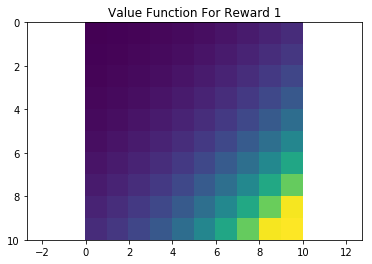

In [486]:
# Question 3: run value iteration and generate heat map on reward 1
estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
V,P = value_iteration(reward_table_1, estimation_step, random_action_prob, gamma)
plot_heat_map(V, "Value Function For Reward 1")

In [487]:
## Question 4: Explain the distribution

# The only reward is at the bottom right, so it makes sense that the value function is higher there.
# The value should decrease as you get away from the reward because we have a discount factor less than one.
# This means if the agent starts at the top left corner, it has a low value because it needs many steps to reach the reward.


In [488]:
# Question 5: Get the policy from the value

# Outputting the policy is already implemented in the value_iteration() method to prevent writing unnecessary code
# We will just implement the plotting of the policy with quivers

def plot_policy(P,title=""):
    U = np.zeros(P.shape)
    V = np.zeros(P.shape)
    for r in range(P.shape[0]):
        for c in range(P.shape[1]):
            # If policy says go up
            if P[r][c] == 0:
                U[r][c], V[r][c] = 0,1
            # If policy says go left
            elif P[r][c] == 1:
                U[r][c], V[r][c] = -1,0
            # If policy says go down
            elif P[r][c] == 2:
                U[r][c], V[r][c] = 0,-1
            # If policy says go right
            elif P[r][c] == 3:
                U[r][c], V[r][c] = 1,0
    plt.quiver(U,V,pivot='mid')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    plt.show()

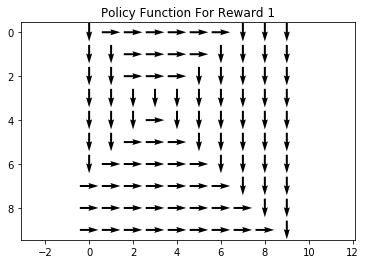

In [489]:
plot_policy(P,"Policy Function For Reward 1")

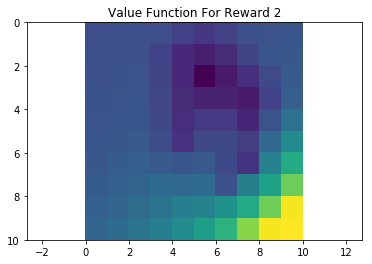

In [490]:
# Question 6, 7: Find the optimal values for Reward 2
estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
V_2,P_2 = value_iteration(reward_table_2, estimation_step, random_action_prob, gamma)
plot_heat_map(V_2, "Value Function For Reward 2")

In [491]:
# Question 8: Explain the distribution

# Close to the reward is still good, with low values near the dangerous territory with reward -100.

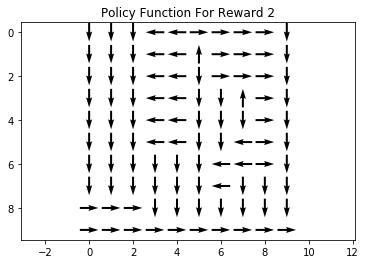

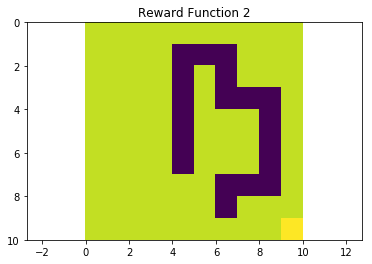

In [492]:
# Question 9: Plot the policy
plot_policy(P_2,"Policy Function For Reward 2")
plot_heat_map(reward_table_2, "Reward Function 2")

In [535]:
estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
V,P = value_iteration(reward_table_1, estimation_step, random_action_prob, gamma)

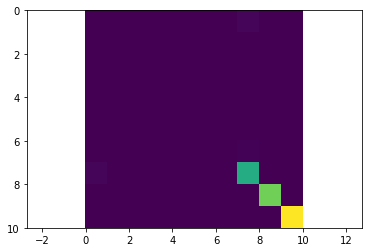

In [541]:


D, b = get_LP_components(P,1,4,0.8,0.1)
c = np.concatenate([np.ones((N,)), -5*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
opt_x = np.array(sol['x'])
R = np.reshape(opt_x[200:],(10,10))
plot_heat_map(R)    

In [495]:
# Generate the optimal and sub-optimal transition matrices
P_a1 = get_trans_from_policy(np.mod(P+0,4), 4, random_action_prob)
P_a2 = get_trans_from_policy(np.mod(P+1,4), 4, random_action_prob)
P_a3 = get_trans_from_policy(np.mod(P+2,4), 4, random_action_prob)
P_a4 = get_trans_from_policy(np.mod(P+3,4), 4, random_action_prob)

In [496]:
# 10-11
    
N = np.ma.size(P)
I_NxN = np.identity(N)
zero_NxN = np.zeros((N,N))

D_row_1 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a2, gamma)],axis=1)
D_row_2 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a3, gamma)],axis=1)
D_row_3 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a4, gamma)],axis=1)
D_row_4 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a2, gamma)],axis=1)
D_row_5 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a3, gamma)],axis=1)
D_row_6 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a4, gamma)],axis=1)
D_row_7 = np.concatenate([zero_NxN, -I_NxN, I_NxN],axis=1)
D_row_8 = np.concatenate([zero_NxN, -I_NxN, -I_NxN],axis=1)
D_row_9 = np.concatenate([zero_NxN, zero_NxN, I_NxN],axis=1)
D_row_10 = np.concatenate([zero_NxN, zero_NxN, -I_NxN],axis=1)
D = np.concatenate([D_row_1,D_row_2,D_row_3,D_row_4,D_row_5,D_row_6,D_row_7,D_row_8,D_row_9,D_row_10],axis=0)
r_max = 1
b = np.concatenate([np.zeros((8*N,)), r_max*np.ones((2*N,))])


In [515]:
estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8

N_lambda = 500
max_lambda = 5
accuracy_vector = np.zeros(N_lambda)

t1 = time.time()
for i,L1 in enumerate(np.linspace(0,max_lambda,N_lambda)):
    if ((i+1) % 10) == 0:
        print("%d of %d complete in %f sec." %(i,N_lambda,time.time()-t1))
        t1 = time.time()
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
    opt_x = np.array(sol['x'])
    R = np.reshape(opt_x[200:],(10,10))
    v,p = value_iteration(R, estimation_step, random_action_prob, gamma)
    accuracy = np.sum(P==p)/p.size
    accuracy_vector[i] = accuracy


9 of 500 complete in 2.911864 sec.
19 of 500 complete in 3.154734 sec.
29 of 500 complete in 2.705666 sec.
39 of 500 complete in 2.801696 sec.
49 of 500 complete in 2.856900 sec.
59 of 500 complete in 3.122323 sec.
69 of 500 complete in 2.568691 sec.
79 of 500 complete in 2.672225 sec.
89 of 500 complete in 2.840940 sec.
99 of 500 complete in 2.830923 sec.
109 of 500 complete in 2.915212 sec.
119 of 500 complete in 3.064593 sec.
129 of 500 complete in 3.329007 sec.
139 of 500 complete in 3.172370 sec.
149 of 500 complete in 3.117141 sec.
159 of 500 complete in 3.294456 sec.
169 of 500 complete in 3.074321 sec.
179 of 500 complete in 3.168338 sec.
189 of 500 complete in 3.384787 sec.
199 of 500 complete in 3.605747 sec.
209 of 500 complete in 3.677128 sec.
219 of 500 complete in 4.039183 sec.
229 of 500 complete in 3.875648 sec.
239 of 500 complete in 3.905126 sec.
249 of 500 complete in 4.724421 sec.
259 of 500 complete in 4.181342 sec.
269 of 500 complete in 3.396784 sec.
279 of 500 c

Text(0,0.5,'Accuracy of Derived Policy')

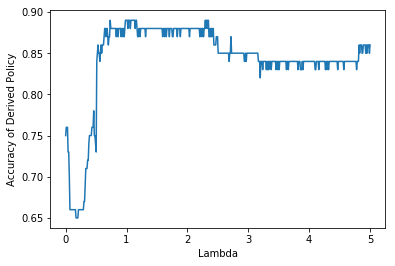

In [516]:
# 11
plt.plot(np.linspace(0,max_lambda,N_lambda),accuracy_vector)
plt.xlabel('Lambda')
plt.ylabel('Accuracy of Derived Policy')

Best Lambda: 2.344689


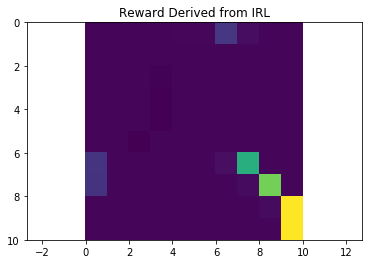

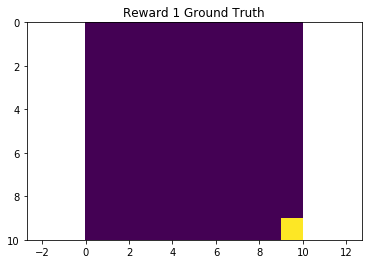

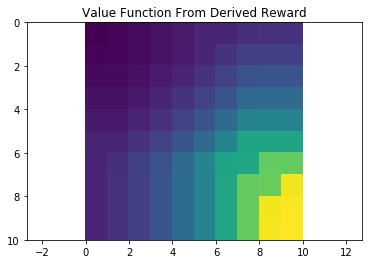

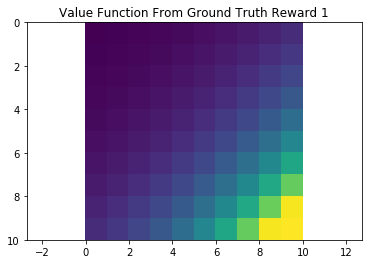

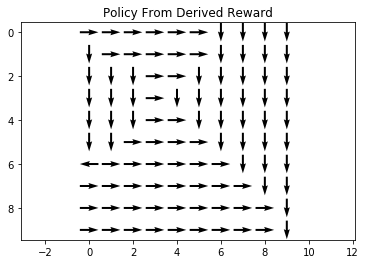

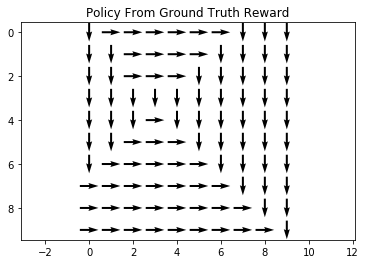

In [533]:
# 12, 13, 14, 15, 16, 17
lambdas = np.linspace(0,max_lambda,N_lambda)
best_lambda = max(lambdas[accuracy_vector==np.max(accuracy_vector)])
print("Best Lambda: %f" % best_lambda)
c = np.concatenate([np.ones((N,)), -best_lambda*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
opt_x = np.array(sol['x'])
R = np.reshape(opt_x[200:],(10,10))

v_best_lambda_1, p_best_lambda_1 = value_iteration(R, estimation_step, random_action_prob, gamma)
v_truth_1, p_truth_1 = value_iteration(reward_table_1, estimation_step, random_action_prob, gamma)
plot_heat_map(R, "Reward Derived from IRL")
plot_heat_map(reward_table_1, "Reward 1 Ground Truth")
plot_heat_map(v_best_lambda_1, "Value Function From Derived Reward")
plot_heat_map(V, "Value Function From Ground Truth Reward 1")
plot_policy(p_best_lambda_1, "Policy From Derived Reward")
plot_policy(p_truth_1, "Policy From Ground Truth Reward")

In [551]:
#18 Sweep lambdas for IRL for reward 2

estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
rmax = 100
V_2,P_2 = value_iteration(reward_table_2, estimation_step, random_action_prob, gamma)
D, b = get_LP_components(P_2,100,4,gamma,random_action_prob)

N_lambda = 500
max_lambda = 5
accuracy_vector = np.zeros(N_lambda)

t1 = time.time()
for i,L1 in enumerate(np.linspace(0,max_lambda,N_lambda)):
    if ((i+1) % 10) == 0:
        print("%d of %d complete in %f sec." %(i,N_lambda,time.time()-t1))
        t1 = time.time()
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
    opt_x = np.array(sol['x'])
    R = np.reshape(opt_x[200:],(10,10))
    v,p = value_iteration(R, estimation_step, random_action_prob, gamma)
    accuracy = np.sum(P_2==p)/p.size
    accuracy_vector[i] = accuracy


9 of 500 complete in 3.871238 sec.
19 of 500 complete in 4.502332 sec.
29 of 500 complete in 4.031804 sec.
39 of 500 complete in 4.319828 sec.
49 of 500 complete in 4.177272 sec.
59 of 500 complete in 3.964700 sec.
69 of 500 complete in 4.019426 sec.
79 of 500 complete in 4.048971 sec.
89 of 500 complete in 4.716089 sec.
99 of 500 complete in 4.203400 sec.
109 of 500 complete in 4.457554 sec.
119 of 500 complete in 4.091968 sec.
129 of 500 complete in 4.238416 sec.
139 of 500 complete in 4.854460 sec.
149 of 500 complete in 5.006031 sec.
159 of 500 complete in 5.046902 sec.
169 of 500 complete in 5.843814 sec.
179 of 500 complete in 4.525114 sec.
189 of 500 complete in 4.948944 sec.
199 of 500 complete in 5.147293 sec.
209 of 500 complete in 4.431343 sec.
219 of 500 complete in 4.458326 sec.
229 of 500 complete in 4.188958 sec.
239 of 500 complete in 3.937866 sec.
249 of 500 complete in 2.248738 sec.
259 of 500 complete in 1.668065 sec.
269 of 500 complete in 1.580452 sec.
279 of 500 c

Text(0,0.5,'Accuracy of Derived Policy For Reward 2')

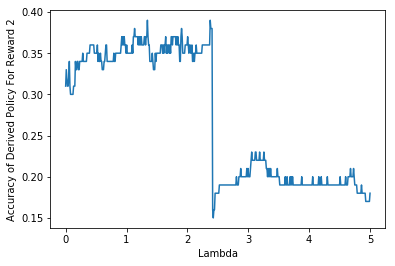

In [552]:
#18
plt.plot(np.linspace(0,max_lambda,N_lambda),accuracy_vector)
plt.xlabel('Lambda')
plt.ylabel('Accuracy of Derived Policy For Reward 2')

Best Lambda: 2.374749


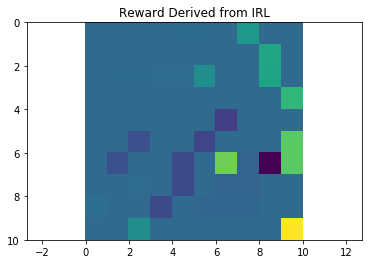

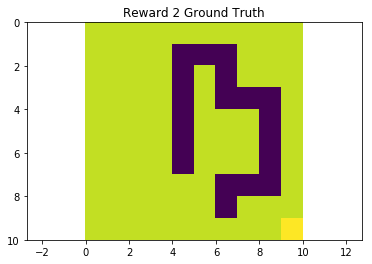

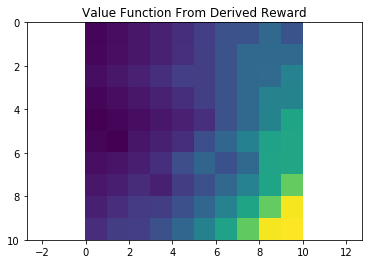

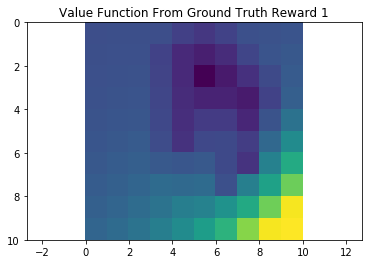

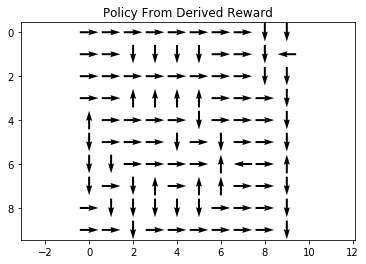

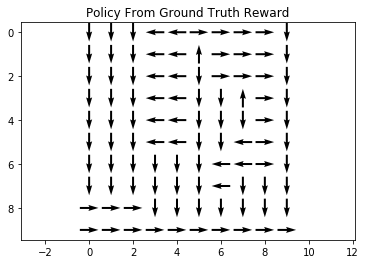

In [553]:
#19-24
lambdas = np.linspace(0,max_lambda,N_lambda)
best_lambda = max(lambdas[accuracy_vector==np.max(accuracy_vector)])
print("Best Lambda: %f" % best_lambda)
D, b = get_LP_components(P_2,100,4,gamma,random_action_prob)
c = np.concatenate([np.ones((N,)), -best_lambda*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
opt_x = np.array(sol['x'])
R = np.reshape(opt_x[200:],(10,10))

v_best_lambda_2, p_best_lambda_2 = value_iteration(R, estimation_step, random_action_prob, gamma)
v_truth_2, p_truth_2 = value_iteration(reward_table_2, estimation_step, random_action_prob, gamma)
plot_heat_map(R, "Reward Derived from IRL")
plot_heat_map(reward_table_2, "Reward 2 Ground Truth")
plot_heat_map(v_best_lambda_2, "Value Function From Derived Reward")
plot_heat_map(v_truth_2, "Value Function From Ground Truth Reward 1")
plot_policy(p_best_lambda_2, "Policy From Derived Reward")
plot_policy(p_truth_2, "Policy From Ground Truth Reward")